# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

К вам как опытному дата-сайентисту обратилось HR- агентство. Ему необходимо исследовать влияние различных факторов, влияющих на оплату труда специалистов Data Science  в различных компаниях, оценить динамику ее изменения, а также отследить иные взаимосвязи в данных.

HR-агентство хочет ответить на следующие вопросы, касающиеся оплаты труда специалистов Data Science:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Какие факторы влияют на зарплату у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о годовых страховых выплатах с указанием характеристик клиентов.

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена зарплата;
*   *experience_level* — опыт работы на этой должности в течение года со следующими возможными значениями:( EN — Entry-level/Junior,MI — Mid-level/Intermediate, SE — Senior-level/Expert, EX — Executive-level/Director);
*   *employment_type* — тип трудоустройства для этой роли:(PT — неполный рабочий день, FT — полный рабочий день, CT — контракт, FL — фриланс);
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — общий объём работы, выполняемой удалённо:(0 — удалённой работы нет (менее 20 %), 50 — частично удалённая работа, 100 — полностью удалённая работа (более 80 %));
*   *company_location* — страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — среднее количество людей, работавших в компании в течение года:(S — менее 50 сотрудников (небольшая компания), M — от 50 до 250 сотрудников (средняя компания), L — более 250 сотрудников (крупная компания));

Источник датасета: “Data Science Job Salaries” (kaggle.com)

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('C:/Users/Vladimir/DS/Module4./ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
data_copy = data

In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [5]:
#Изучаем структуру данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


In [7]:
data.nunique()

Unnamed: 0            607
work_year               3
experience_level        4
employment_type         4
job_title              50
salary                272
salary_currency        17
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

### Анализ заработной платы у специалистов Data Science 

In [8]:
#Создаем датафрейм с данными по Data Scientist
data_ds = data.loc[data['job_title'] == 'Data Scientist']
data_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 599
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          143 non-null    int64 
 1   work_year           143 non-null    int64 
 2   experience_level    143 non-null    object
 3   employment_type     143 non-null    object
 4   job_title           143 non-null    object
 5   salary              143 non-null    int64 
 6   salary_currency     143 non-null    object
 7   salary_in_usd       143 non-null    int64 
 8   employee_residence  143 non-null    object
 9   remote_ratio        143 non-null    int64 
 10  company_location    143 non-null    object
 11  company_size        143 non-null    object
dtypes: int64(5), object(7)
memory usage: 14.5+ KB


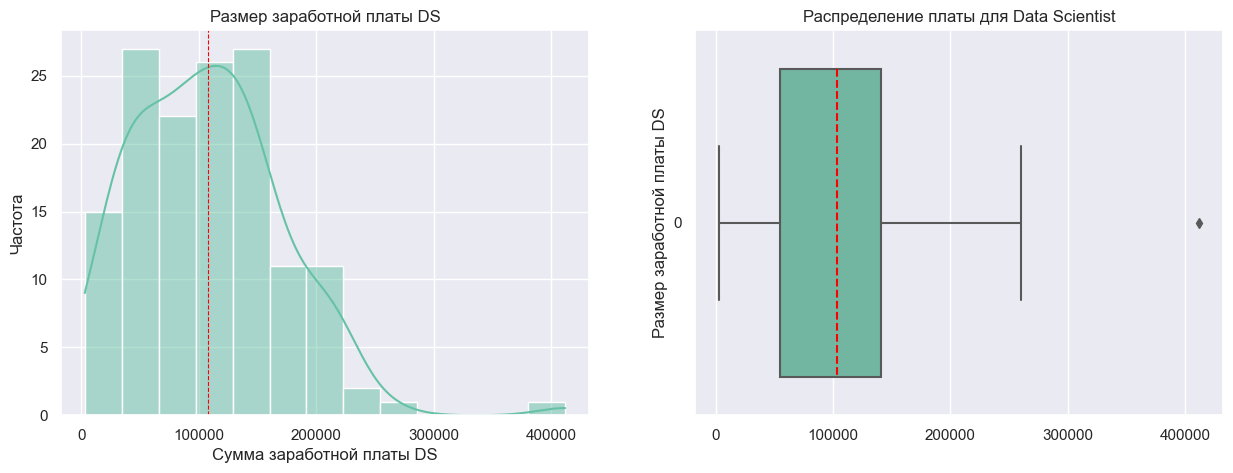

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_ds['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Сумма заработной платы DS', ylabel='Частота')
axes[0].set_title('Размер заработной платы DS')
axes[0].axvline(data_ds['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_ds['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы DS')
axes[1].set_title('Распределение платы для Data Scientist')

plt.show()

Распределение заработной платы отлично от нормального, имеются выбросы.

In [10]:
data_ds.nunique()

Unnamed: 0            143
work_year               3
experience_level        3
employment_type         3
job_title               1
salary                 91
salary_currency        14
salary_in_usd         108
employee_residence     27
remote_ratio            3
company_location       24
company_size            3
dtype: int64

In [11]:
#Анализируем заработную плату DS
data_agg = data_ds['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Анализ заработной платы DS']
data_agg

,Анализ заработной платы DS
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


work_year
2020     85970.523810
2021     70671.733333
2022    136172.090909
Name: salary_in_usd, dtype: float64

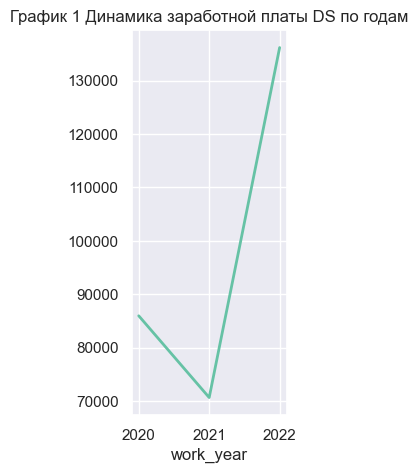

In [12]:
salary_dynamics = data_ds.groupby(['work_year'])['salary_in_usd'].mean()
display(salary_dynamics)
salary_dynamics.plot(
    kind='line',
    figsize=(2, 5),
    title='График 1 Динамика заработной платы DS по годам',
    grid = True,
    lw=2
);

# Выводы
Поскольку временной ряд датафрейма кортокий( состоит всего из 3 значений), выводы носят приблизительный характер. Зарплата специалистов Data Science в 2021 г. упала на 18% по сравнению с 2020 г., но в 2022 г. она выросла на 93% по сравнению с предыдущим годом и на 58% по сравнению с 2020г. Подобный рост связан, вероятно, с окончанием пандемии и динамикой индустрии в целом. При этом надо иметь в виду, что анализировалась зарплата в долларах, при этом работники расположены в 27 странах, так что рост может отчасти объясняться колебаниями курсов валют. 

### Анализ факторов, влияющих на зарплату специалистов Data Science

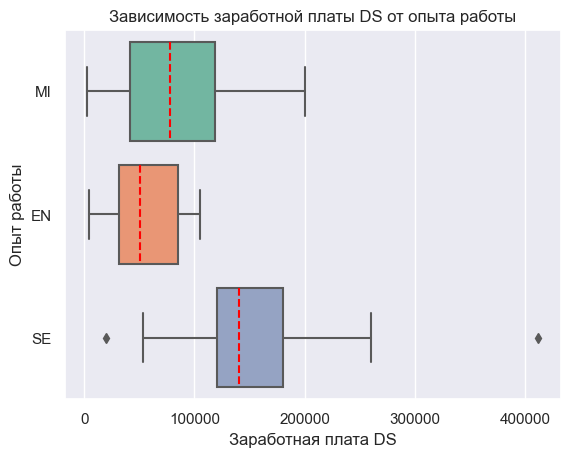

In [13]:
#Рассматриваем влияние опыта работы на размер заработной платы 
ax = sns.boxplot(data_ds, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата DS', ylabel='Опыт работы')
plt.title('Зависимость заработной платы DS от опыта работы')
plt.show()

In [14]:
data_agg = data_ds.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от опыта работы')
data_agg

Заработная плата в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


На первый взгляд опыт работы существенно влияет на уровень заарплаты DS. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях

In [15]:
#Выделяем данные по специальностям Data Scientist и Data Engineer
data_experts = [ 'Data Scientist', 'Data Engineer']
data_dsde = data_copy.loc[data['job_title'].isin(data_experts)]

In [16]:
#Создаем датафрейм с данными совместно по Data Scientist Data Engineer
data_dsde.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 0 to 603
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          275 non-null    int64 
 1   work_year           275 non-null    int64 
 2   experience_level    275 non-null    object
 3   employment_type     275 non-null    object
 4   job_title           275 non-null    object
 5   salary              275 non-null    int64 
 6   salary_currency     275 non-null    object
 7   salary_in_usd       275 non-null    int64 
 8   employee_residence  275 non-null    object
 9   remote_ratio        275 non-null    int64 
 10  company_location    275 non-null    object
 11  company_size        275 non-null    object
dtypes: int64(5), object(7)
memory usage: 27.9+ KB


In [17]:
import plotly.express as px
# Построение диаграммы соотношения зарплат Data Scientist и Data Engineer в различных компаниях
bar_data = data_dsde.groupby(['company_size', 'job_title'],
                           as_index=False)['salary_in_usd'].mean()
fig = px.bar(
    data_frame=bar_data,
    y='company_size',
    x='salary_in_usd',
    barmode='group',
    color='job_title',
    title='Зарплата в зависимости от размера компании' ,
    orientation='h'
)
fig.show()

# Выводы
Заработные платы Data Scientist и Data Engineer меняются в зависимости от размера компании. Наиболее высокие зарплаты у данных специалистов обнаружены в компаниях среднего размера, они практически вдвое превосходят зарплаты таких специалистов в малых компаниях. Зарплаты специалистов в крупных компаниях примерно на 20% ниже, чем в средних, что, возможно, может объясняться тем, что крупные компании имеют более широкую специализацию и придерживаются более сдержанной политики оплаты труда. Любопытно отметить, что в малых компаниях зарплата Data Engineer на 28% выше чем зарплата Data Scientist, а в средних компаниях - наоборот, зарплата Data Scientist на 6% выше чем зарплата Data Engineer. В свою очередь, зарплаты этих специалистов в больших компаниях практически равны. Скорее всего, размер компании так или иначе связан с ее специализацией, то есть она нанимает и выше оплачивает тех, кто приносит ей бОльший доход.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

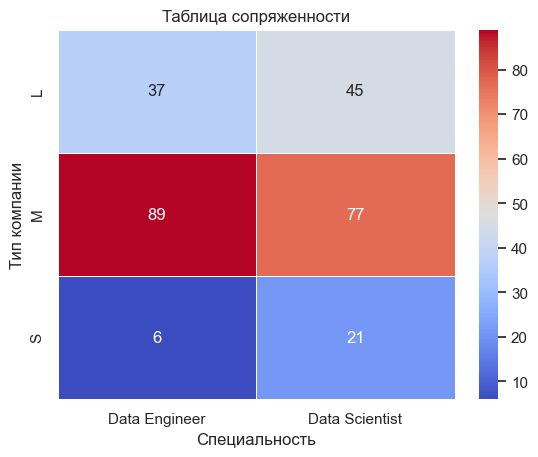

In [18]:
cross_tab = pd.crosstab(index=data_dsde['company_size'], columns=data['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Специальность', ylabel='Тип компании')
plt.title('Таблица сопряженности')
plt.show()

Анализ показывает, что бОльшая часть специалистов работает в компаниях среднего размера(  54% всех Data Scientist и 67% всех Data Engineer). При этом в малых компаниях специалистов Data Scientistв 3.5 раза больше, чем Data Engineer.

## Статистический анализ данных



In [19]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Размер заработной платы специалиста Data Scientist в последущий год выше, чем заработная плата специалиста Data Scientist в предыдущий год?

**Проверка на нормальность**

Построенная выше гистограмма показывает, что распределение отличается от нормального, проверка на нормальность не требуется



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Краскела - Уоллеса для сравнения распределений на основе рангов.

**Проведём тест**

In [20]:
salary_2020 = data_ds.loc[data_ds['work_year']=='2020', 'salary_in_usd']
salary_2021 = data_ds.loc[data_ds['work_year']=='2021', 'salary_in_usd']
salary_2022 = data_ds.loc[data_ds['work_year']=='2022', 'salary_in_usd']

# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = nan
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер заработной платы Data Scientist в последующем году выше чем в предыдущем. Как мы видели на вышеприведенном графике, зарабоная плата сначала снижается, а потом идет вверх.

### Влияет ли опыт работы на размер заработной платы специалистов Data Scientist?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровни заработной платы у начинающих работников (EN) ($μ_1$), работников среднего уровня ()($μ_2$) и экспертов () ($μ_3$) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): Уровни заработной платы у начинающих работников (EN) ($μ_1$), работников среднего уровня ()($μ_2$) и экспертов () ($μ_3$) неодинаковы.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$





**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [21]:
# значения заработной платы DS
salary_EN = data_ds.loc[data_ds['experience_level']=='EN', 'salary_in_usd']
salary_MI = data_ds.loc[data_ds['experience_level']=='MI', 'salary_in_usd']
salary_SE = data_ds.loc[data_ds['experience_level']=='SE', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для EN:')
result = stats.shapiro(salary_EN)
decision_normality(result[1])

print('Для MI:')
result = stats.shapiro(salary_MI)
decision_normality(result[1])

print('Для SE:')
result = stats.shapiro(salary_SE)
decision_normality(result[1])

Для EN:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для MI:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Краскела — Уоллеса.

**Проведём тест**


In [22]:
# проводим тест
_, p = stats.kruskal(salary_EN, salary_MI, salary_SE)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы зависит от опыта работы специалистов.

### Как соотносятся зарплаты Data Scientist  и Data Engineer в различных компаниях?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы не отличается в разных компаниях: малых(S) ($μ_1$), средних(M) ($μ_2$), крупных(L) ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы отличается в разных компаниях: малых(S) ($μ_1$), средних(M) ($μ_2$), крупных(L) ($μ_3$).


$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [30]:
# значения заработной платы
salary_S = data_dsde.loc[data_dsde['company_size']=='S', 'salary_in_usd']
#display(salary_S)
salary_M = data_dsde.loc[data_dsde['company_size']=='M', 'salary_in_usd']
#display(salary_M)
salary_L = data_dsde.loc[data_dsde['company_size']=='L', 'salary_in_usd']
#display(salary_L)


# проводим тест Шапиро-Уилка
print('Для малых компаний:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Для средних компаний:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Для крупных компаний:')
result = stats.shapiro(salary_L)
decision_normality(result[1])




Для малых компаний:
p-value = 0.517
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних компаний:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупных компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [31]:
# проводим тест
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы зависит от размера компании.

### Есть ли взаимосвязь между наличием должностей Data Scientist и Data Engineer и  размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между размером компании, и наличием должностей Data Scientist и Data Engineer нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между размером компании, и наличием должностей Data Scientist и Data Engineer есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака "Специальность»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [32]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data_dsde['company_size'], data_dsde['job_title'])

cross_table

job_title,Data Engineer,Data Scientist
company_size,,
L,37,45
M,89,77
S,6,21


In [33]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между размером компании и наличием в ней должностей Data Scientist и  Data Engineer.

## Итоговые результаты исследования

*   Нет оснований утверждать, что размер заработной платы Data Scientist растет.
*   Уровень заработной платы зависит от опыта работы специалистов.
*   Уровень заработной платы зависит от размера компании.
*   Существует взаимосвязь между размером компании и наличием в ней должностей Data Scientist и  Data Engineer

### Дополнительное исследование

Работаем с копией исходного датасета data_copy

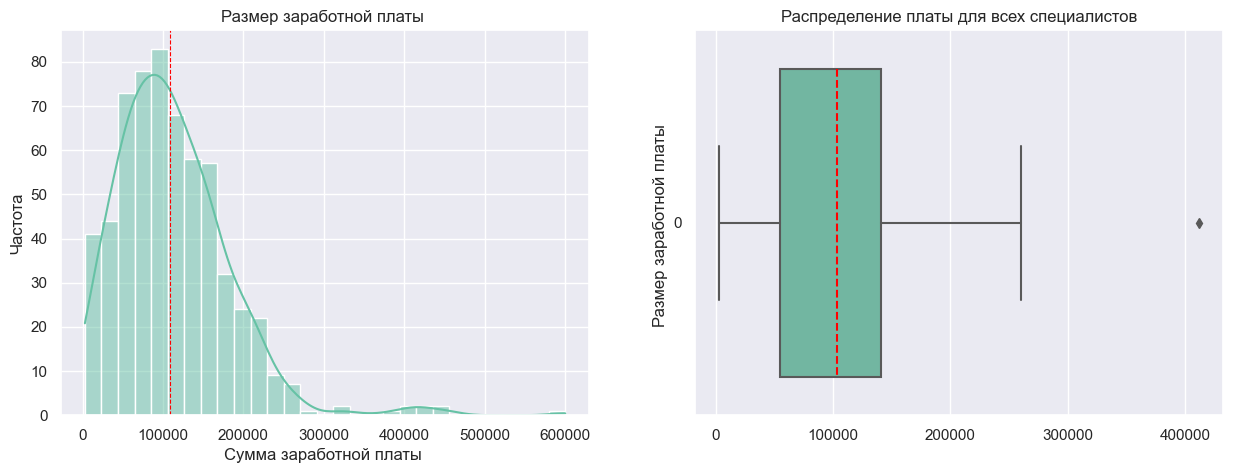

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_copy['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Сумма заработной платы ', ylabel='Частота')
axes[0].set_title('Размер заработной платы ')
axes[0].axvline(data_ds['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_ds['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы ')
axes[1].set_title('Распределение платы для всех специалистов')

plt.show()

Распределение заработной платы отлично от нормального, имеются выбросы.

In [35]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


## Анализ влияния типа занятости на зарплату специалистов

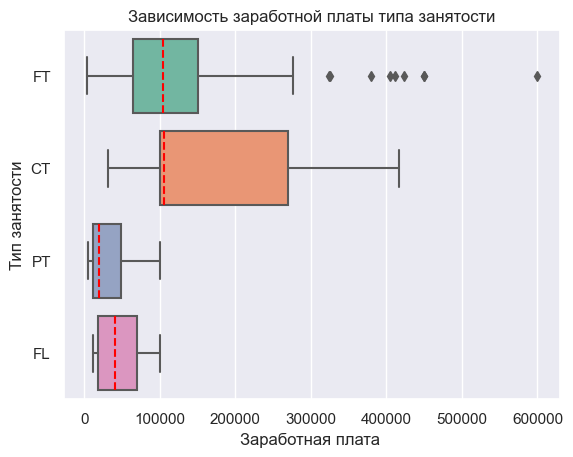

In [37]:
#Рассматриваем влияние типа занятости на размер заработной платы 
ax = sns.boxplot(data_copy, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата ', ylabel='Тип занятости')
plt.title('Зависимость заработной платы типа занятости')
plt.show()

In [38]:
data_agg = data_copy.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от типа занятости')
data_agg

Заработная плата в зависимости от типа занятости


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


# Выводы
Тип занятости существенно влияет на уровень зарплаты специалистов. Чтобы определить, являются ли эти различия статистически значимыми, проведём статистическое тестирование.

### Влияет ли тип занятости на размер заработной платы специалистов ?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровни заработной платы у полностьью занятых (FT) ($μ_1$), работающих неполный день (PT)($μ_2$), контрактников (CT)($μ_3$) и фрилансеров (FL) ($μ_4$) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3= μ_4$$

*Альтернативная гипотеза* ($H_1$):Уровни заработной платы у полностьью занятых (FT) ($μ_1$), работающих неполный день (PT)($μ_2$), контрактников (CT)($μ_3$) и фрилансеров (FL) ($μ_4$) неодинаковы .

$$ H_1 : μ_1 \neq μ_2 \neq μ_3\neq μ_4$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [39]:
# значения заработной платы 
salary_FT = data_copy.loc[data_copy['employment_type']=='FT', 'salary_in_usd']
salary_PT = data_copy.loc[data_copy['employment_type']=='PT', 'salary_in_usd']
salary_CT = data_copy.loc[data_copy['employment_type']=='CT', 'salary_in_usd']
salary_FL = data_copy.loc[data_copy['employment_type']=='FL', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для FT:')
result = stats.shapiro(salary_FT)
decision_normality(result[1])

print('Для PT:')
result = stats.shapiro(salary_PT)
decision_normality(result[1])

print('Для CT:')
result = stats.shapiro(salary_CT)
decision_normality(result[1])

print('Для FL:')
result = stats.shapiro(salary_FL)
decision_normality(result[1])

Для FT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для PT:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для CT:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FL:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Краскела — Уоллеса.

**Проведём тест**

In [40]:
# проводим тест
_, p = stats.kruskal(salary_FT, salary_PT, salary_CT, salary_FL)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы зависит от типа занятости специалистов.

In [41]:
#Подготовка данных для анализа зависимости зарплаты и объема удаленной работы
data_copy.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [44]:
#Заменяем численные значения в столбце, описывающем объем работы, выполненной удаленно
data_copy['remote_ratio'] = data_copy['remote_ratio'].replace([0,50,100], ['ZR', 'HF','FL'])
data_copy.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,ZR,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,ZR,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,HF,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,ZR,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,HF,US,L


## Анализ влияния объема удаленной работы на зарплату специалистов

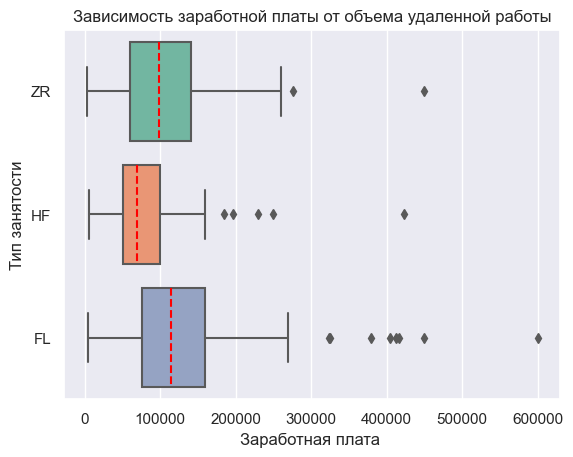

In [45]:
#Рассматриваем влияние объема удаленной работы на размер заработной платы 
ax = sns.boxplot(data_copy, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата ', ylabel='Тип занятости')
plt.title('Зависимость заработной платы от объема удаленной работы')
plt.show()

# Выводы
Объем удаленной работы влияет на уровень зарплаты специалистов. Чтобы определить, являются ли эти различия статистически значимыми, проведём статистическое тестирование.

### Влияет ли объем удаленной работы на размер заработной платы специалистов ?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровни заработной платы у специалистов, у которых удалённой работы нет (менее 20 %)(ZR)($μ_1$), у специалистов, работающих частично удалённо(HF)($μ_2$), у специалистов, полностью работающих удалённо (более 80 %)(FL)($μ_3$) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$):Уровни заработной платы у специалистов, у которых удалённой работы нет (менее 20 %)(ZR)($μ_1$), у специалистов, работающих частично удалённо(HF)($μ_2$), у специалистов, полностью работающих удалённо (более 80 %)(FL)($μ_3$) неодинаковы.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [46]:
# значения заработной платы 
salary_ZR = data_copy.loc[data_copy['remote_ratio']=='ZR', 'salary_in_usd']
salary_HF = data_copy.loc[data_copy['remote_ratio']=='HF', 'salary_in_usd']
salary_FL = data_copy.loc[data_copy['remote_ratio']=='FL', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для ZR:')
result = stats.shapiro(salary_ZR)
decision_normality(result[1])

print('Для HF:')
result = stats.shapiro(salary_HF)
decision_normality(result[1])

print('Для FL:')
result = stats.shapiro(salary_FL)
decision_normality(result[1])


Для ZR:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для HF:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для FL:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Краскела — Уоллеса.

**Проведём тест**

In [47]:
# проводим тест
_, p = stats.kruskal(salary_ZR, salary_HF, salary_FL)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы зависит от объема удаленной работы.

# Итоговые результаты дополнительных исследований

*   Уровень заработной платы зависит от типа занятости специалистов.
*   Уровень заработной платы зависит от объема удаленной работы.
